---
Capsnet
---

# Introducción a las Redes CapsNet

Las **Redes CapsNet** son una arquitectura propuesta por Geoffrey Hinton et al., diseñadas para preservar relaciones espaciales y estructurales en los datos. A diferencia de las redes neuronales convolucionales (CNN), las CapsNet utilizan **cápsulas**, que son grupos de neuronas que representan tanto la probabilidad de que una entidad esté presente como sus propiedades poseídas (como orientación, tamaño, etc.).

## 1. Representación de las Cápsulas

Una cápsula se define como un vector \( $\mathbf{u} \in \mathbb{R}^d $\), donde:
- La magnitud \( $||\mathbf{u}|| $\) representa la probabilidad de que la entidad representada esté presente.
- La dirección del vector \( $\mathbf{u}$ \) codifica las propiedades poseídas por la entidad.

Para garantizar que \($ ||\mathbf{u}|| \leq 1$ \), se utiliza una función de "compresión" o **squashing**:


$$\mathbf{v} = \frac{||\mathbf{u}||^2}{1 + ||\mathbf{u}||^2} \frac{\mathbf{u}}{||\mathbf{u}||}$$


donde \( $\mathbf{v} $\) es el vector comprimido.

---

## 2. Enrutamiento por Acuerdo

El proceso de **enrutamiento por acuerdo** se utiliza para conectar cápsulas entre capas. En lugar de usar conexiones fijas, las salidas de las cápsulas se "enrutran" dinámicamente a través de un proceso iterativo que utiliza pesos de afinidad \( $c_{ij}$ \).

### 2.1 Cálculo de las predicciones

Cada cápsula de entrada genera predicciones \( $\hat{\mathbf{u}}_{j|i}$ \) para las cápsulas de salida:


$$\hat{\mathbf{u}}_{j|i} = \mathbf{W}_{ij} \mathbf{u}_i$$


donde:
- \( $\mathbf{W}_{ij} \in \mathbb{R}^{d_{\text{out}} \times d_{\text{in}}}$ \) es una matriz de pesos aprendida.
- \( $\mathbf{u}_i $\) es la salida de la cápsula de entrada \( $i $\).

---

### 2.2 Enrutamiento iterativo

1. Inicializar los pesos de afinidad \($ b_{ij} = 0$ \).
2. Calcular los coeficientes de afinidad \($ c_{ij}$ \) mediante softmax:
   $$c_{ij} = \frac{\exp(b_{ij})}{\sum_k \exp(b_{ik})}$$
   
3. Combinar las predicciones ponderadas para calcular la suma ponderada:
   $$\mathbf{s}_j = \sum_i c_{ij} \hat{\mathbf{u}}_{j|i}$$

4. Aplicar la función de compresión a \($ \mathbf{s}_j$ \) para obtener la salida de la cápsula de destino \( $j $\):
   $$\mathbf{v}_j = \text{squash}(\mathbf{s}_j)$$
   
5. Actualizar los pesos de afinidad:
  $$ b_{ij} = b_{ij} + \hat{\mathbf{u}}_{j|i} \cdot \mathbf{v}_j$$
   

Este proceso se repite durante un número predefinido de iteraciones.

---

## 3. Función de Pérdida

La CapsNet utiliza una **función de margen** para las salidas \( \mathbf{v} \):

$$L_k = T_k \max(0, m^+ - ||\mathbf{v}_k||)^2 + \lambda (1 - T_k) \max(0, ||\mathbf{v}_k|| - m^-)^2$$


donde:
- \( $T_k = 1$ \) si la clase \( $k$\) está presente, y 0 en caso contrario.
- \( $m^+ $\) y \($ m^- $\) son márgenes hiperparámetros.
- \( $\lambda $\) es un hiperparámetro que controla la contribución de las clases incorrectas.

---

Esta arquitectura permite que las CapsNet sean más robustas para aprender y reconocer relaciones espaciales complejas en los datos, lo que las hace ideales para tareas como clasificación y segmentación.

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np

# Función squash
def squash(tensor, dim=-1):
    squared_norm = (tensor ** 2).sum(dim=dim, keepdim=True)
    scale = squared_norm / (1.0 + squared_norm)
    tensor_squashed = scale * tensor / torch.sqrt(squared_norm + 1e-8)
    return tensor_squashed

# Clase CapsuleLayer
class CapsuleLayer(nn.Module):
    def __init__(self, num_capsules, num_routes, in_channels, out_channels, num_iterations=3):
        super(CapsuleLayer, self).__init__()
        self.num_capsules = num_capsules
        self.num_routes = num_routes
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.num_iterations = num_iterations

        # Inicializar W con varianza reducida
        self.W = nn.Parameter(0.01 * torch.randn(1, num_routes, num_capsules, out_channels, in_channels))

    def forward(self, x):
        batch_size = x.size(0)
        x = x.unsqueeze(2).unsqueeze(4)  # x: [batch_size, num_routes, 1, in_channels, 1]
        W = self.W.repeat(batch_size, 1, 1, 1, 1)  # W: [batch_size, num_routes, num_capsules, out_channels, in_channels]
        u_hat = torch.matmul(W, x)  # u_hat: [batch_size, num_routes, num_capsules, out_channels, 1]
        b_ij = torch.zeros(batch_size, self.num_routes, self.num_capsules, 1).to(x.device)  # b_ij: [batch_size, num_routes, num_capsules, 1]

        for iteration in range(self.num_iterations):
            c_ij = F.softmax(b_ij, dim=2)  # c_ij: [batch_size, num_routes, num_capsules, 1]
            c_ij = c_ij.unsqueeze(-1)  # c_ij: [batch_size, num_routes, num_capsules, 1, 1]
            s_j = (c_ij * u_hat).sum(dim=1, keepdim=True)  # s_j: [batch_size, 1, num_capsules, out_channels, 1]
            v_j = squash(s_j, dim=-2)  # v_j: [batch_size, 1, num_capsules, out_channels, 1]
            if iteration < self.num_iterations - 1:
                a_ij = (u_hat * v_j).sum(dim=-1, keepdim=True)
                b_ij = b_ij + a_ij.squeeze(-1)
        v_j = v_j.squeeze(1).squeeze(-1).squeeze(-1)  # v_j: [batch_size, num_capsules, out_channels]
        return v_j

# Clase CapsNet
class CapsNet(nn.Module):
    def __init__(self):
        super(CapsNet, self).__init__()
        # Primera capa convolucional
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=256, kernel_size=9, stride=1)

        # Cápsulas primarias
        self.primary_capsules = nn.Conv2d(in_channels=256, out_channels=8*32, kernel_size=9, stride=2)

        # Cápsulas de dígitos
        self.num_capsules = 10
        self.digit_capsules = CapsuleLayer(
            num_capsules=self.num_capsules,
            num_routes=32 * 6 * 6,
            in_channels=8,
            out_channels=16
        )

        # Decodificador para reconstrucción
        self.decoder = nn.Sequential(
            nn.Linear(16 * self.num_capsules, 512),
            nn.ReLU(inplace=True),
            nn.Linear(512, 1024),
            nn.ReLU(inplace=True),
            nn.Linear(1024, 28 * 28),
            nn.Sigmoid()
        )

    def forward(self, x):
        # Primera capa convolucional
        x = F.relu(self.conv1(x), inplace=True)
        # Cápsulas primarias
        x = self.primary_capsules(x)
        x = x.view(x.size(0), 8, -1).transpose(1, 2)
        x = x.contiguous()
        x = x.view(x.size(0), -1, 8)
        # Cápsulas de dígitos
        capsule_outputs = self.digit_capsules(x)
        # Aplanar para el decodificador
        x_flat = capsule_outputs.view(capsule_outputs.size(0), -1)
        # Reconstrucción
        reconstructions = self.decoder(x_flat)
        return capsule_outputs, reconstructions

# Clase CapsuleLoss
class CapsuleLoss(nn.Module):
    def __init__(self):
        super(CapsuleLoss, self).__init__()
        self.reconstruction_loss = nn.MSELoss()

    def forward(self, images, labels, capsule_outputs, reconstructions):
        # Pérdida de margen
        v_c = torch.sqrt((capsule_outputs ** 2).sum(dim=-1) + 1e-8)
        max_l = F.relu(0.9 - v_c) ** 2
        max_r = F.relu(v_c - 0.1) ** 2
        T_c = labels
        margin_loss = T_c * max_l + 0.5 * (1.0 - T_c) * max_r
        margin_loss = margin_loss.sum(dim=1).mean()

        # Pérdida de reconstrucción con factor de escala ajustado
        reconstruction_loss = self.reconstruction_loss(reconstructions, images.view(images.size(0), -1))
        total_loss = margin_loss + 0.005 * reconstruction_loss  # Aumentar el factor de escala

        return total_loss

# Preparar el dataset MNIST
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset  = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

batch_size = 128
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

# Definir el dispositivo
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Crear el modelo y moverlo al dispositivo
model = CapsNet().to(device)

# Inicializar los pesos
def weights_init(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight)
        if m.bias is not None:
            nn.init.zeros_(m.bias)

model.apply(weights_init)

# Definir el optimizador
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Definir la función de pérdida
criterion = CapsuleLoss()

# Funciones de entrenamiento y prueba
def train(model, train_loader, optimizer, criterion, epoch):
    model.train()
    total_loss = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        capsule_outputs, reconstructions = model(data)

        # Crear etiquetas one-hot
        y = F.one_hot(target, num_classes=10).float().to(device)

        # Calcular la pérdida
        loss = criterion(data, y, capsule_outputs, reconstructions)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

        if batch_idx % 100 == 0:
            print(f'Epoch [{epoch}] Batch [{batch_idx}/{len(train_loader)}] Loss: {loss.item():.4f}')
            v_c = torch.sqrt((capsule_outputs ** 2).sum(dim=-1) + 1e-8)

    average_loss = total_loss / len(train_loader)
    return average_loss

def test(model, test_loader, criterion):
    model.eval()
    test_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            capsule_outputs, reconstructions = model(data)
            y = F.one_hot(target, num_classes=10).float().to(device)
            loss = criterion(data, y, capsule_outputs, reconstructions)
            test_loss += loss.item()

            # Predicciones
            v_c = torch.sqrt((capsule_outputs ** 2).sum(dim=-1) + 1e-8)
            _, predicted = v_c.max(dim=1)
            correct += (predicted == target).sum().item()
            total += target.size(0)
    average_loss = test_loss / len(test_loader)
    accuracy = 100. * correct / total
    print(f'Test Loss: {average_loss:.4f}, Accuracy: {accuracy:.2f}%')
    return average_loss, accuracy

# Entrenar el modelo
num_epochs = 4
train_losses = []
test_losses = []
test_accuracies = []

for epoch in range(1, num_epochs + 1):
    train_loss = train(model, train_loader, optimizer, criterion, epoch)
    test_loss, test_accuracy = test(model, test_loader, criterion)

    train_losses.append(train_loss)
    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)


Epoch [1] Batch [0/469] Loss: 0.8139
Epoch [1] Batch [100/469] Loss: 0.0891
Epoch [1] Batch [200/469] Loss: 0.0567
Epoch [1] Batch [300/469] Loss: 0.0311
Epoch [1] Batch [400/469] Loss: 0.0347
Test Loss: 0.0340, Accuracy: 98.29%
Epoch [2] Batch [0/469] Loss: 0.0266
Epoch [2] Batch [100/469] Loss: 0.0289
Epoch [2] Batch [200/469] Loss: 0.0270
Epoch [2] Batch [300/469] Loss: 0.0282
Epoch [2] Batch [400/469] Loss: 0.0224
Test Loss: 0.0247, Accuracy: 98.68%
Epoch [3] Batch [0/469] Loss: 0.0207
Epoch [3] Batch [100/469] Loss: 0.0135
Epoch [3] Batch [200/469] Loss: 0.0275
Epoch [3] Batch [300/469] Loss: 0.0257
Epoch [3] Batch [400/469] Loss: 0.0247
Test Loss: 0.0236, Accuracy: 98.86%
Epoch [4] Batch [0/469] Loss: 0.0276
Epoch [4] Batch [100/469] Loss: 0.0194
Epoch [4] Batch [200/469] Loss: 0.0193
Epoch [4] Batch [300/469] Loss: 0.0184
Epoch [4] Batch [400/469] Loss: 0.0275
Test Loss: 0.0218, Accuracy: 98.68%


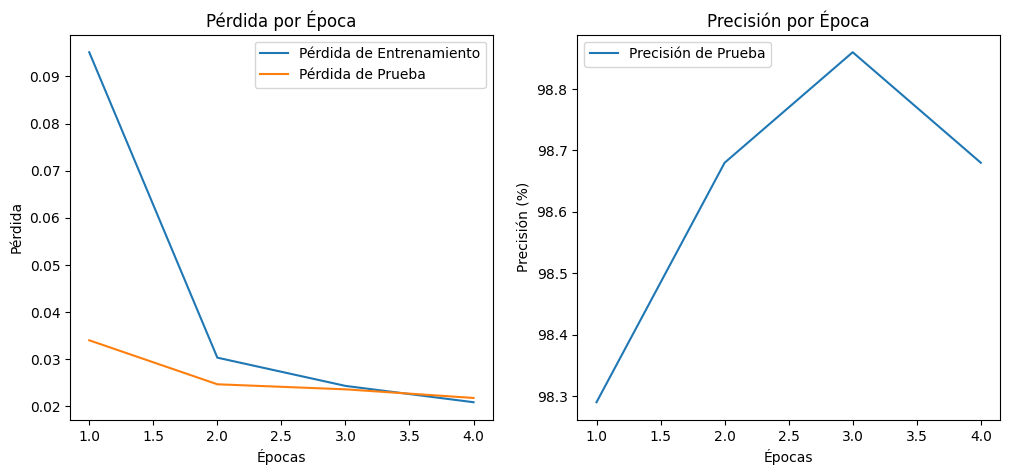

In [2]:
# Gráfico de la pérdida
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(range(1, num_epochs + 1), train_losses, label='Pérdida de Entrenamiento')
plt.plot(range(1, num_epochs + 1), test_losses, label='Pérdida de Prueba')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.title('Pérdida por Época')
plt.legend()

# Gráfico de la precisión
plt.subplot(1,2,2)
plt.plot(range(1, num_epochs + 1), test_accuracies, label='Precisión de Prueba')
plt.xlabel('Épocas')
plt.ylabel('Precisión (%)')
plt.title('Precisión por Época')
plt.legend()
plt.show()

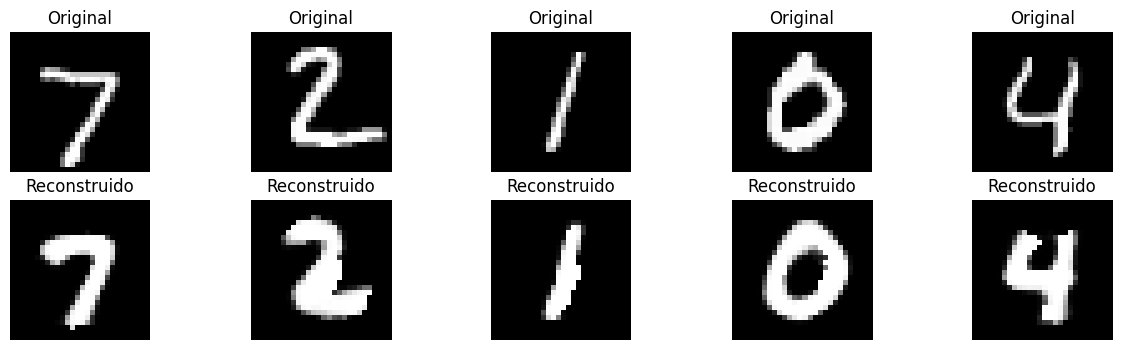

In [3]:
def visualize_reconstructions(model, data_loader):
    model.eval()
    data_iter = iter(data_loader)
    images, labels = next(data_iter)
    images = images.to(device)
    with torch.no_grad():
        capsule_outputs, reconstructions = model(images)
    
    images = images.cpu().numpy()
    reconstructions = reconstructions.view(-1, 1, 28, 28).cpu().numpy()
    
    num_images = 5
    fig, axes = plt.subplots(nrows=2, ncols=num_images, figsize=(15,4))
    for i in range(num_images):
        # Imagen original
        axes[0, i].imshow(images[i].reshape(28,28), cmap='gray')
        axes[0, i].set_title(f'Original')
        axes[0, i].axis('off')
        
        # Reconstrucción
        axes[1, i].imshow(reconstructions[i].reshape(28,28), cmap='gray')
        axes[1, i].set_title(f'Reconstruido')
        axes[1, i].axis('off')
    plt.show()

# Visualizar reconstrucciones en el conjunto de prueba
visualize_reconstructions(model, test_loader)

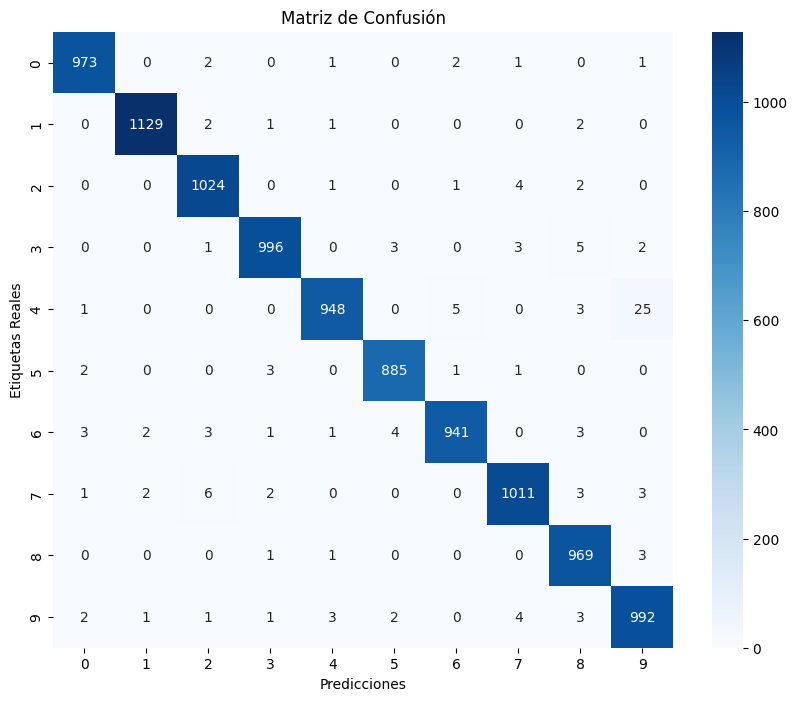

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       980
           1       1.00      0.99      1.00      1135
           2       0.99      0.99      0.99      1032
           3       0.99      0.99      0.99      1010
           4       0.99      0.97      0.98       982
           5       0.99      0.99      0.99       892
           6       0.99      0.98      0.99       958
           7       0.99      0.98      0.99      1028
           8       0.98      0.99      0.99       974
           9       0.97      0.98      0.97      1009

    accuracy                           0.99     10000
   macro avg       0.99      0.99      0.99     10000
weighted avg       0.99      0.99      0.99     10000



In [4]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

def evaluate_model(model, data_loader):
    model.eval()
    all_preds = []
    all_targets = []
    with torch.no_grad():
        for data, target in data_loader:
            data = data.to(device)
            capsule_outputs, _ = model(data)
            v_c = torch.sqrt((capsule_outputs ** 2).sum(dim=-1) + 1e-8)
            _, predicted = v_c.max(dim=1)
            all_preds.extend(predicted.cpu().numpy())
            all_targets.extend(target.numpy())
    return np.array(all_targets), np.array(all_preds)

# Obtener predicciones y etiquetas reales
targets, preds = evaluate_model(model, test_loader)

# Calcular la matriz de confusión
conf_matrix = confusion_matrix(targets, preds)

# Mostrar la matriz de confusión
plt.figure(figsize=(10,8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicciones')
plt.ylabel('Etiquetas Reales')
plt.title('Matriz de Confusión')
plt.show()

# Mostrar el reporte de clasificación
print(classification_report(targets, preds))

## Referencias:
	•	Hinton, G. E., Sabour, S., & Frosst, N. (2017). Dynamic Routing Between Capsules. arXiv preprint arXiv:1710.09829.